In [1]:
import cv2
import numpy as np
import pandas as pd
import pytesseract as tess
from matplotlib import pyplot as plt

In [2]:
import Levenshtein as lev
from skimage.filters.rank import entropy
from pytesseract import Output

### DOCUMENT IMAGE

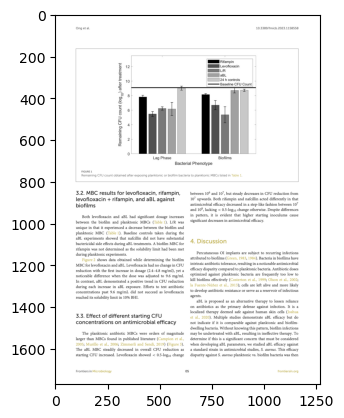

In [3]:
imgPDF = cv2.imread('./../samples/imgPDF.png')
imgPDF.shape

plt.imshow(imgPDF)

In [4]:
GT = tess.image_to_string(imgPDF)
print(GT)

Ong et al.

10.3389/fmicb.2023.1158558

Rifampin
EE Levofloxacin
GLR
BL

24 h controls
Baseline CFU Count

Biofilms

Bacterial Phenotype

& 12
FS
©
g
= 10
£
‘Ss 1
<)
ao 8
2
5
3 6
8
b=)
im
O 4
D
]
=
©
E 2
[a]
ow

i?)

Lag Phase
FIGURE 1
Remaining CFU count obtained after exposing planktonic or biofilm bacteria to planktonic MBCs listed in Table 1.

3.2. MBC results for levofloxacin, rifampin,
levofloxacin + rifampin, and aBL against
biofilms

Both levofloxacin and aBL had significant dosage increases
between the biofilm and planktonic MBCs (Table 1). L/R was
unique in that it experienced a decrease between the biofilm and
planktonic MBC (Table 1). Baseline controls taken during the
aBL experiments showed that nafcillin did not have substantial
bactericidal side effects during aBL treatments. A biofilm MBC for
rifampin was not determined as the solubility limit had been met
during planktonic experiments.

Figure 2 shows data obtained while determining the biofilm
MBC for levofloxacin and

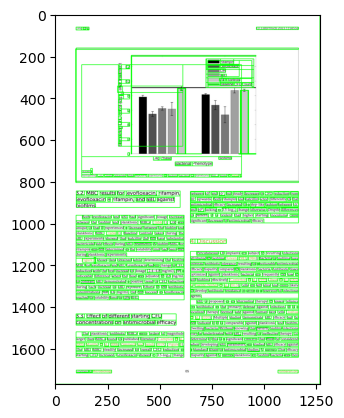

In [5]:
img = imgPDF.copy()
d = tess.image_to_data(img, output_type=tess.Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(img)

In [7]:
d.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [8]:
print("pages : ",np.unique(d['page_num']),"\nlevels : ", np.unique(d['level']),"\nblocks:",np.unique(d['block_num']))

pages :  [1] 
levels :  [1 2 3 4 5] 
blocks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


In [9]:
print("paragraphs : ",np.unique(d['par_num']),"\nlines : ", np.unique(d['line_num']),"\nwords:",np.unique(d['word_num']))

paragraphs :  [0 1 2 3] 
lines :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
words: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [10]:
words = d['text']
len(words)

750

In [11]:
words_filt = [word for word in words if len(word) >= 1]
len(words_filt)

560

In [12]:
df = pd.DataFrame(d)
df.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1270,1770,-1,
1,2,1,1,0,0,0,100,62,62,14,-1,
2,3,1,1,1,0,0,100,62,62,14,-1,
3,4,1,1,1,1,0,100,62,62,14,-1,
4,5,1,1,1,1,1,100,62,28,14,96,Ong


In [15]:
df.describe(include='object')

,text
count,750
unique,319
top,
freq,190


In [22]:
for col in df.columns:
    uniq = df[col].unique()
    if(len(uniq) < 20):
        print(col, uniq)
    else :
        print(col,"count:", len(uniq))

level [1 2 3 4 5]
page_num [1]
block_num count: 35
par_num [0 1 2 3]
line_num count: 24
word_num [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
left count: 391
top count: 206
width count: 136
height count: 49
conf count: 50
text count: 319


In [39]:
df.groupby(['level'])['text'].nunique()

level
1      1
2      1
3      1
4      1
5    319
Name: text, dtype: int64

<AxesSubplot:>

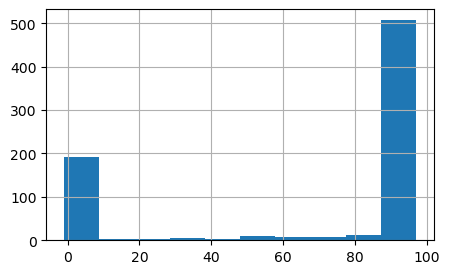

In [47]:
plt.figure(figsize=(5,3))
df['conf'].hist()

<AxesSubplot:>

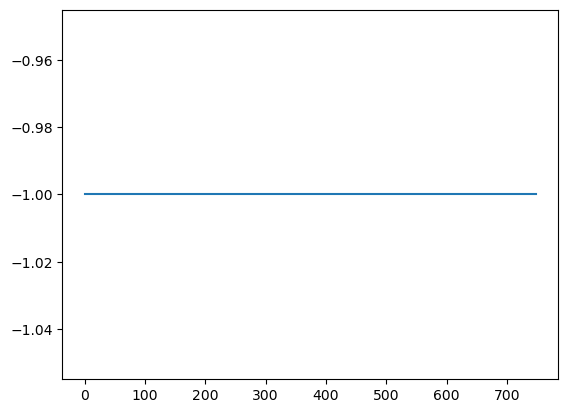

In [50]:
df[df['level'] < 5]['conf'].plot()

In [ ]:
df.groupby(['level'])['text'].nunique()

In [13]:
df.shape

(750, 12)

In [ ]:
df[df['text'] != ''].shape

In [ ]:
df.dropna(subset=['text'])

In [ ]:
df.groupby(['level','block_num','par_num'])['text'].unique()

In [ ]:
df[df['conf'] > 0]

In [ ]:
df_words = df[df['text'] != '']
df_words

In [ ]:
df_words.sort_values(['left','top'])

In [ ]:
df[(df['conf'] > 0) & (df['text'].str.len() > 4)]

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [ ]:
min_conf = 1
min_word_len = 3
window = 200

In [ ]:
idx = df[(df['conf'] >= min_conf) & (df['text'].str.len() > min_word_len)]['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])).index
df_filter = df.iloc[idx]
df_filter.reset_index(inplace=True, drop=True)
df_filter

In [ ]:
def getCoordinates(row):
    left, top, width, height = row['left'], row['top'], row['width'], row['height']
    coord = (int(left + (width / 2)), int(top + (height / 2)))
    return coord

df_filter[['y_coord','x_coord']] = df_filter.apply(lambda x: getCoordinates(x),axis=1,result_type='expand')
df_filter

In [ ]:
def getNeighbors(word, img, df , window_size):
    y_coord,x_coord = df[df['text'] == word].iloc[0][['y_coord','x_coord']]
    
    
    
    c1 = df['x_coord'].isin(range(x_coord-window_size,x_coord+window_size))
    c2 = df['y_coord'].isin(range(y_coord-window_size,y_coord+window_size))
    
    return list(df[c1 & c2].text)

In [ ]:
df_filter['neighbors'] = df_filter.apply(lambda x: getNeighbors(x.loc['text'],imgPDF,df_filter,window),axis=1)
df_filter

In [ ]:
def plot_patch(word, img, df , window_size):
    y_coord,x_coord, neighbors = df[df['text'] == word].iloc[0][['y_coord','x_coord','neighbors']]
    print(x_coord, y_coord, neighbors)
    
    patch_img = img[x_coord-window_size:x_coord+window_size,y_coord-window_size:y_coord+window_size]
    print(tess.image_to_string(patch_img))
    plt.imshow(patch_img)

In [ ]:
plot_patch('Bacterial', imgPDF, df_filter , window)

In [ ]:
plt.imshow(imgPDF)

In [ ]:
OriginalTokenPairs = [(row['text'], item) for _, row in df_filter.iterrows() for item in row['neighbors']]
OriginalTokenPairs = [(x, y) for x, y in OriginalTokenPairs if x != y]
OriginalTokenPairs = list(set(OriginalTokenPairs))
OriginalTokenPairs

In [ ]:
len(OriginalTokenPairs)

### CAMERA IMAGE

In [ ]:
img = cv2.imread('./../samples/WarpedRes.jpg')
img.shape

plt.imshow(img)

In [ ]:
GT1 = tess.image_to_string(img)
print(GT1)

In [ ]:
temp = img.copy()
d = tess.image_to_data(temp, output_type=tess.Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(temp)

In [ ]:
data2 = tess.image_to_data(img, output_type=tess.Output.DICT)
data2

In [ ]:
df2 = pd.DataFrame(data2)
df2

In [ ]:
idx = df2[(df2['conf'] > min_conf) & (df2['text'].str.len() > min_word_len)]['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])).index
df2_filter = df2.iloc[idx]
df2_filter.reset_index(inplace=True, drop=True)
df2_filter

In [ ]:
df2_filter[['y_coord','x_coord']] = df2_filter.apply(lambda x: getCoordinates(x),axis=1,result_type='expand')
df2_filter

In [ ]:
df2_filter['neighbors'] = df2_filter.apply(lambda x: getNeighbors(x.loc['text'],img,df2_filter,window),axis=1)
df2_filter

In [ ]:
CapturedTokenPairs = [(row['text'], item) for _, row in df2_filter.iterrows() for item in row['neighbors']]
CapturedTokenPairs = [(x, y) for x, y in CapturedTokenPairs if x != y]
CapturedTokenPairs = list(set(CapturedTokenPairs))
CapturedTokenPairs

In [ ]:
len(CapturedTokenPairs)

In [ ]:
c = set( OriginalTokenPairs).intersection(set(CapturedTokenPairs))
len(c),c

In [ ]:
def apply_rules(word):
    rules = {
        'ceoCDQ0': 'c',
        '7Zz': 'z',
        'YVyv': 'v',
        'IijJLl1': 'i',
        '9gq': 'g',
        'li': 'h',
        'f,t': 'f',
        '68': '6',
        'BEF': 'B',
        'ri': 'n',
        'tn': 'm',
        'rn': 'm',
        'nn': 'm',
        'cl': 'd',
        'el': 'd'
    }
    
    for rule, replacement in rules.items():
        word = word.replace(rule, replacement)
    return word

In [ ]:
OriginalTokenPairs1 = [(apply_rules(word1), apply_rules(word2)) for word1, word2 in OriginalTokenPairs]
OriginalTokenPairs1

In [ ]:
len(OriginalTokenPairs1)

In [ ]:
CapturedTokenPairs1 = [(apply_rules(word1), apply_rules(word2)) for word1, word2 in CapturedTokenPairs]
CapturedTokenPairs1

In [ ]:
len(CapturedTokenPairs1)

In [ ]:
c = set( OriginalTokenPairs1).intersection(set(CapturedTokenPairs1))
len(c),c

what are the previous nums?
whats the previous DB?

### PART OF IMAGE

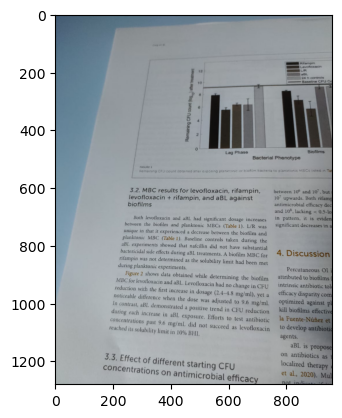

In [51]:
img3 = cv2.imread('./../samples/img3.jpeg')
img3.shape

plt.imshow(img3)

In [ ]:
tess.image_to_string(img3)

<BarContainer object of 256 artists>

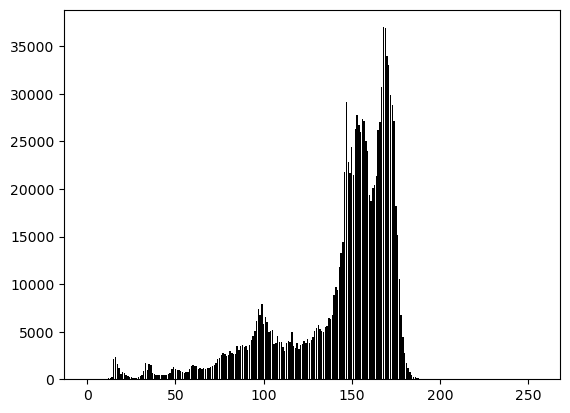

In [52]:
intensity_hist1 = cv2.calcHist([img3], [0], None, [256], [0, 255])
intensity_hist1 = np.reshape(intensity_hist1,(intensity_hist1.shape[0]))
plt.bar(range(256),intensity_hist1,color='black')

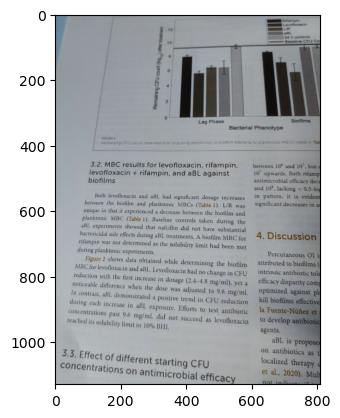

In [53]:
temp2 = img3[150:,150:]
plt.imshow(temp2)

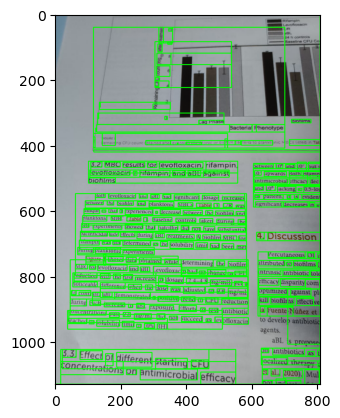

In [54]:
temp = temp2.copy()
d = tess.image_to_data(temp, output_type=tess.Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(temp)

In [ ]:
tess.image_to_string(temp2)

In [ ]:
data3 = tess.image_to_data(temp2, output_type=tess.Output.DICT)
data3

In [ ]:
df3 = pd.DataFrame(data3)
df3

In [ ]:
idx = df3[(df3['conf'] > min_conf) & (df3['text'].str.len() > min_word_len)]['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])).index
df3_filter = df3.iloc[idx]
df3_filter.reset_index(inplace=True, drop=True)
df3_filter

In [ ]:
df3_filter[['y_coord','x_coord']] = df3_filter.apply(lambda x: getCoordinates(x),axis=1,result_type='expand')
df3_filter

In [ ]:
df3_filter['neighbors'] = df3_filter.apply(lambda x: getNeighbors(x.loc['text'],img,df3_filter,window),axis=1)
df3_filter

In [ ]:
CapturedTokenPairs = [(row['text'], item) for _, row in df3_filter.iterrows() for item in row['neighbors']]
CapturedTokenPairs = [(x, y) for x, y in CapturedTokenPairs if x != y]
CapturedTokenPairs = list(set(CapturedTokenPairs))
CapturedTokenPairs

In [ ]:
len(CapturedTokenPairs)

In [ ]:
c = set( OriginalTokenPairs).intersection(set(CapturedTokenPairs))
len(c),c

In [ ]:
def apply_rules(word):
    rules = {
        'ceoCDQ0': 'c',
        '7Zz': 'z',
        'YVyv': 'v',
        'IijJLl1': 'i',
        '9gq': 'g',
        'li': 'h',
        'f,t': 'f',
        '68': '6',
        'BEF': 'B',
        'ri': 'n',
        'tn': 'm',
        'rn': 'm',
        'nn': 'm',
        'cl': 'd',
        'el': 'd'
    }
    
    for rule, replacement in rules.items():
        word = word.replace(rule, replacement)
    return word

In [ ]:
OriginalTokenPairs1 = [(apply_rules(word1), apply_rules(word2)) for word1, word2 in OriginalTokenPairs]
OriginalTokenPairs1

In [ ]:
CapturedTokenPairs1 = [(apply_rules(word1), apply_rules(word2)) for word1, word2 in CapturedTokenPairs]
CapturedTokenPairs1

In [ ]:
c = set( OriginalTokenPairs1).intersection(set(CapturedTokenPairs1))
len(c),c